<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-3/blob/main/notebooks/Q5_3_AIML425_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=2dc11fa9a70bc2f333adcb9bc2229e865214c9b5a2ef5a5ddb9f583297cb9109
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [ ]:
# !pip install --upgrade networkx

In [63]:
import torch
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from scipy.sparse import csr_matrix
import numpy as np
import pickle

In [64]:
def sensor_score(tiger_passed_by, c):
    s = random.uniform(0, 1)  # Random float between 0 and 1

    if tiger_passed_by:
        return s
    else:
        if s < c:
            return 2 * s / c
        else:
            return 2 * (1 - s) / (1 - c)


In [65]:
def generate_data(F=0.1, c=1e-9):
    # Grid dimensions
    n = 32  # 32x32 grid
    N = n * n  # Total number of sensors

    # Generate grid with failures and sensor scores
    grid = torch.zeros(n, n)
    for i in range(n):
        for j in range(n):
            if random.random() < F:
                grid[i, j] = 0  # Sensor failed
            else:
                grid[i, j] = sensor_score(False, c)  # Initialize with sensor_score

    # Initialize the tiger's track
    edge = random.choice(["top", "bottom", "left", "right"])
    if edge == "top":
        x, y = 0, random.randint(0, n-1)
    elif edge == "bottom":
        x, y = n-1, random.randint(0, n-1)
    elif edge == "left":
        x, y = random.randint(0, n-1), 0
    else:  # edge == "right"
        x, y = random.randint(0, n-1), n-1

    # Track of the tiger
    track = [(x, y)]

    # Simulate the tiger's movement
    while True:
        dx, dy = random.choice([(-1, -1), (-1, 0), (-1, 1),
                                (0, -1),           (0, 1),
                                (1, -1),  (1, 0),  (1, 1)])
        x, y = x + dx, y + dy

        # Check for exit conditions
        exit_edge = None
        if x < 0:
            exit_edge = "top"
        elif x >= n:
            exit_edge = "bottom"
        elif y < 0:
            exit_edge = "left"
        elif y >= n:
            exit_edge = "right"

        if exit_edge and exit_edge != edge:
            break  # Tiger has left the grid from a different edge

        # If within grid, update the track and grid
        if 0 <= x < n and 0 <= y < n:
            track.append((x, y))

    y_label = torch.zeros(n, n).long()

    # Update grid values for the track
    for x, y in track:
        grid[x, y] = sensor_score(True, c)  # Update with sensor_score
        y_label[x, y] = 1

    # Create adjacency matrix
    adj_matrix = torch.zeros(N, N)
    for i in range(n):
        for j in range(n):
            if grid[i, j] == 0:  # Skip failed sensors
                continue
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue  # Skip self-loop
                    x, y = i + dx, j + dy
                    if 0 <= x < n and 0 <= y < n and grid[x, y] != 0:
                        index1 = i * n + j
                        index2 = x * n + y
                        adj_matrix[index1, index2] = 1

    # print(len(track))

    # Convert to PyTorch Geometric Data
    edge_index = adj_matrix.nonzero().t().contiguous()
    x = grid.view(-1, 1)  # Node features (sensor scores)
    y_label = y_label.view(-1)  # Flatten the label tensor
    data = Data(x=x, edge_index=edge_index, y=y_label)
    return data

In [66]:
# Generate multiple instances
num_instances = 10
all_data = [generate_data() for _ in range(num_instances)]

In [67]:
# # Save to disk
# with open("all_data.pkl", "wb") as f:
#     pickle.dump(all_data, f)

# # Load from disk
# with open("all_data.pkl", "rb") as f:
#     all_data = pickle.load(f)

In [68]:
# Split into train and test sets
train_size = int(0.8 * len(all_data))
train_data = all_data[:train_size]
test_data = all_data[train_size:]

# Plot

In [69]:
n = 32

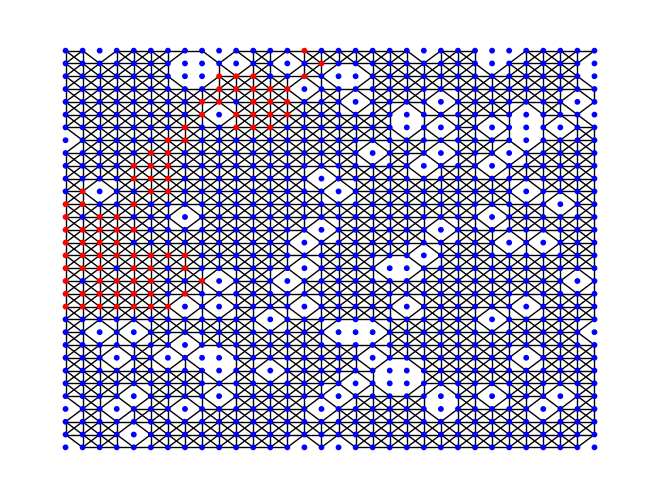

In [76]:
# Extract the first data object from train_data
first_data = train_data[2]

# Extract adjacency matrix and node features
edge_index = first_data.edge_index.numpy()
y = first_data.y.view(-1).numpy()

# Create adjacency matrix from edge_index
N = len(y)
adj_matrix = torch.zeros(N, N)
for i, j in edge_index.T:
    adj_matrix[i, j] = 1

# Convert to SciPy sparse matrix
adj_matrix_numpy = adj_matrix.numpy()
adj_matrix_sparse = csr_matrix(adj_matrix_numpy)

# To visualize the graph, we convert it to a networkx graph and plot
G = nx.from_scipy_sparse_array(adj_matrix_sparse)
pos = {i: [(i // n) % n, i % n] for i in range(N)}
node_colors = ['red' if val == 1 else 'blue' for val in y]

# Use a colormap to map the sensor score to a color
nx.draw(G, pos, node_size=10, node_color=node_colors, cmap=plt.cm.viridis_r, vmin=0, vmax=1)

# Add a colorbar to show the mapping from sensor score to color
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
# plt.colorbar(sm, orientation='vertical', label='Sensor Score')

plt.show()


<ipython-input-73-924531267611>:29: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



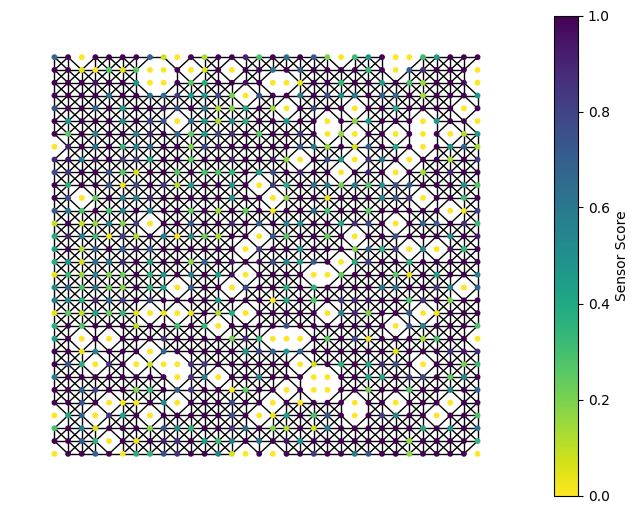

In [73]:
# Extract the first data object from train_data
first_data = train_data[2]

# Extract adjacency matrix and node features
edge_index = first_data.edge_index.numpy()
x = first_data.x.view(-1).numpy()

# Create adjacency matrix from edge_index
N = len(x)
adj_matrix = torch.zeros(N, N)
for i, j in edge_index.T:
    adj_matrix[i, j] = 1

# Convert to SciPy sparse matrix
adj_matrix_numpy = adj_matrix.numpy()
adj_matrix_sparse = csr_matrix(adj_matrix_numpy)

# To visualize the graph, we convert it to a networkx graph and plot
G = nx.from_scipy_sparse_array(adj_matrix_sparse)
pos = {i: [(i // n) % n, i % n] for i in range(N)}
node_colors = [x[i] for i in range(N)]

# Use a colormap to map the sensor score to a color
nx.draw(G, pos, node_size=10, node_color=node_colors, cmap=plt.cm.viridis_r, vmin=0, vmax=1)

# Add a colorbar to show the mapping from sensor score to color
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, orientation='vertical', label='Sensor Score')

plt.show()


In [24]:
first_data.x

tensor([[1.2104],
        [0.3777],
        [0.1638],
        ...,
        [1.0737],
        [0.6097],
        [1.6720]])

In [25]:
first_data.edge_index

tensor([[   0,    0,    0,  ..., 1023, 1023, 1023],
        [   1,   32,   33,  ...,  990,  991, 1022]])

In [26]:
first_data.y

tensor([0, 0, 0,  ..., 0, 0, 0])

# Train model

In [27]:
import torch
import numpy as np
from torch_geometric.nn import GCNConv
from torch.nn import BCELoss
import torch.optim as optim
from sklearn.metrics import f1_score

# Define the GNN model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

# Function to train the model
def train_model(model, train_data, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = BCELoss()
    model.train()
    for epoch in range(epochs):
        for data in train_data:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out.view(-1), data.y.float())
            loss.backward()
            optimizer.step()

# Function to evaluate the model
def evaluate_model(model, test_data):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_data:
            out = model(data)
            pred = (out > 0.5).float().view(-1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())
    return y_true, y_pred




In [28]:
# Initialize and train the model
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = BCELoss()
model.train()

Net(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 1)
)

In [29]:
for data in train_data:
    optimizer.zero_grad()
    out = model(data)
    print(type(out))
    print(out.view(-1))
    print(data.y)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    optimizer.step()

<class 'torch.Tensor'>
tensor([0.4984, 0.4982, 0.4986,  ..., 0.4983, 0.4982, 0.4984],
       grad_fn=<ViewBackward0>)
tensor([0, 0, 0,  ..., 0, 0, 0])
<class 'torch.Tensor'>
tensor([0.4902, 0.4888, 0.4890,  ..., 0.4862, 0.4872, 0.4890],
       grad_fn=<ViewBackward0>)
tensor([0, 0, 0,  ..., 0, 0, 0])
<class 'torch.Tensor'>
tensor([0.4916, 0.4719, 0.4730,  ..., 0.4748, 0.4772, 0.4818],
       grad_fn=<ViewBackward0>)
tensor([0, 0, 0,  ..., 0, 0, 0])
<class 'torch.Tensor'>
tensor([0.4702, 0.4637, 0.4627,  ..., 0.4762, 0.4748, 0.4772],
       grad_fn=<ViewBackward0>)
tensor([0, 0, 0,  ..., 1, 1, 1])
<class 'torch.Tensor'>
tensor([0.4579, 0.4540, 0.4537,  ..., 0.4546, 0.4505, 0.4578],
       grad_fn=<ViewBackward0>)
tensor([0, 0, 0,  ..., 0, 0, 0])
<class 'torch.Tensor'>
tensor([0.4465, 0.4413, 0.4388,  ..., 0.4397, 0.4301, 0.4367],
       grad_fn=<ViewBackward0>)
tensor([0, 0, 0,  ..., 0, 0, 0])
<class 'torch.Tensor'>
tensor([0.4319, 0.4198, 0.4301,  ..., 0.4220, 0.4250, 0.4730],
       g

In [31]:
# Initialize results dictionary
results = {}

# Generate F and c values
F_values = np.linspace(0, 1, 5)  # Example: 5 values from 0 to 1
c_values = np.logspace(-9, 0, 5)  # Example: 5 values from 1e-9 to 1

# Loop over different F and c values
for F in F_values:
    for c in c_values:
        print(F, c)
        # Generate data
        num_instances = 10  # Example: 100 instances
        all_data = [generate_data(F=F, c=c) for _ in range(num_instances)]

        # Split data (80% train, 20% test)
        train_size = int(0.8 * len(all_data))
        train_data = all_data[:train_size]
        test_data = all_data[train_size:]

        # Initialize and train the model
        model = Net()
        train_model(model, train_data)

        # Evaluate the model
        y_true, y_pred = evaluate_model(model, test_data)

        # Compute F1-score as an example metric
        f1 = f1_score(y_true, y_pred)

        # Store the results
        results[(F, c)] = f1

0.0 1e-09
0.0 1.7782794100389227e-07
0.0 3.1622776601683795e-05
0.0 0.005623413251903491
0.0 1.0
0.25 1e-09
0.25 1.7782794100389227e-07
0.25 3.1622776601683795e-05
0.25 0.005623413251903491
0.25 1.0
0.5 1e-09
0.5 1.7782794100389227e-07
0.5 3.1622776601683795e-05
0.5 0.005623413251903491
0.5 1.0
0.75 1e-09
0.75 1.7782794100389227e-07
0.75 3.1622776601683795e-05
0.75 0.005623413251903491
0.75 1.0
1.0 1e-09
1.0 1.7782794100389227e-07
1.0 3.1622776601683795e-05
1.0 0.005623413251903491
1.0 1.0
F1-scores for different F and c values:
F: 0.0, c: 1e-09, F1-score: 0.0
F: 0.0, c: 1.7782794100389227e-07, F1-score: 0.0
F: 0.0, c: 3.1622776601683795e-05, F1-score: 0.611764705882353
F: 0.0, c: 0.005623413251903491, F1-score: 0.07407407407407407
F: 0.0, c: 1.0, F1-score: 0.0
F: 0.25, c: 1e-09, F1-score: 0.0
F: 0.25, c: 1.7782794100389227e-07, F1-score: 0.0
F: 0.25, c: 3.1622776601683795e-05, F1-score: 0.0
F: 0.25, c: 0.005623413251903491, F1-score: 0.0
F: 0.25, c: 1.0, F1-score: 0.0
F: 0.5, c: 1e-09

In [32]:
# Print the results
print("F1-scores for different F and c values:")
for (F, c), f1 in results.items():
    print(f"F: {F}, c: {c}, F1-score: {f1}")

F1-scores for different F and c values:
F: 0.0, c: 1e-09, F1-score: 0.0
F: 0.0, c: 1.7782794100389227e-07, F1-score: 0.0
F: 0.0, c: 3.1622776601683795e-05, F1-score: 0.611764705882353
F: 0.0, c: 0.005623413251903491, F1-score: 0.07407407407407407
F: 0.0, c: 1.0, F1-score: 0.0
F: 0.25, c: 1e-09, F1-score: 0.0
F: 0.25, c: 1.7782794100389227e-07, F1-score: 0.0
F: 0.25, c: 3.1622776601683795e-05, F1-score: 0.0
F: 0.25, c: 0.005623413251903491, F1-score: 0.0
F: 0.25, c: 1.0, F1-score: 0.0
F: 0.5, c: 1e-09, F1-score: 0.0
F: 0.5, c: 1.7782794100389227e-07, F1-score: 0.0
F: 0.5, c: 3.1622776601683795e-05, F1-score: 0.0
F: 0.5, c: 0.005623413251903491, F1-score: 0.0
F: 0.5, c: 1.0, F1-score: 0.0
F: 0.75, c: 1e-09, F1-score: 0.0
F: 0.75, c: 1.7782794100389227e-07, F1-score: 0.0
F: 0.75, c: 3.1622776601683795e-05, F1-score: 0.0
F: 0.75, c: 0.005623413251903491, F1-score: 0.0
F: 0.75, c: 1.0, F1-score: 0.0
F: 1.0, c: 1e-09, F1-score: 1.0
F: 1.0, c: 1.7782794100389227e-07, F1-score: 1.0
F: 1.0, c: 

In [33]:
results

{(0.0, 1e-09): 0.0,
 (0.0, 1.7782794100389227e-07): 0.0,
 (0.0, 3.1622776601683795e-05): 0.611764705882353,
 (0.0, 0.005623413251903491): 0.07407407407407407,
 (0.0, 1.0): 0.0,
 (0.25, 1e-09): 0.0,
 (0.25, 1.7782794100389227e-07): 0.0,
 (0.25, 3.1622776601683795e-05): 0.0,
 (0.25, 0.005623413251903491): 0.0,
 (0.25, 1.0): 0.0,
 (0.5, 1e-09): 0.0,
 (0.5, 1.7782794100389227e-07): 0.0,
 (0.5, 3.1622776601683795e-05): 0.0,
 (0.5, 0.005623413251903491): 0.0,
 (0.5, 1.0): 0.0,
 (0.75, 1e-09): 0.0,
 (0.75, 1.7782794100389227e-07): 0.0,
 (0.75, 3.1622776601683795e-05): 0.0,
 (0.75, 0.005623413251903491): 0.0,
 (0.75, 1.0): 0.0,
 (1.0, 1e-09): 1.0,
 (1.0, 1.7782794100389227e-07): 1.0,
 (1.0, 3.1622776601683795e-05): 0.9967637540453074,
 (1.0, 0.005623413251903491): 1.0,
 (1.0, 1.0): 1.0}

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


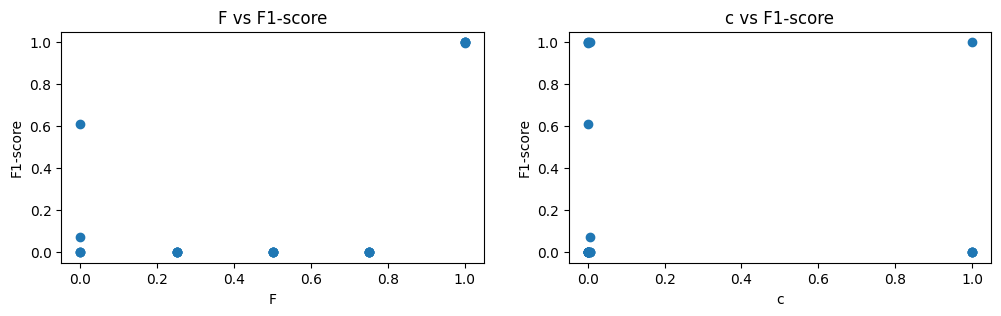

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x, y, and z coordinates
x = [key[0] for key in results.keys()]
y = [key[1] for key in results.keys()]
z = list(results.values())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Plot x vs z
axs[0].scatter(x, z)
axs[0].set_title('F vs F1-score')
axs[0].set_xlabel('F')
axs[0].set_ylabel('F1-score')

# Plot y vs z
axs[1].scatter(y, z)
axs[1].set_title('c vs F1-score')
axs[1].set_xlabel('c')
axs[1].set_ylabel('F1-score')

# Show the plots
plt.show()


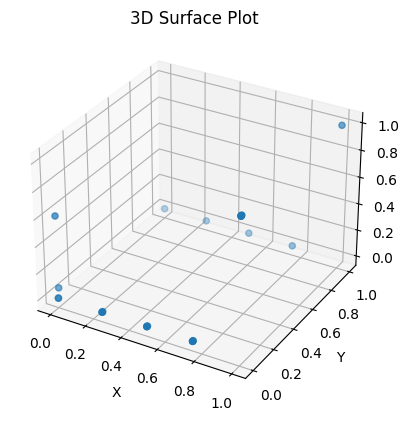

In [36]:
# Extract x, y, and z coordinates
x = [key[0] for key in results.keys()]
y = [key[1] for key in results.keys()]
z = list(results.values())

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.scatter(x, y, z)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot')

# Show the plot
plt.show()

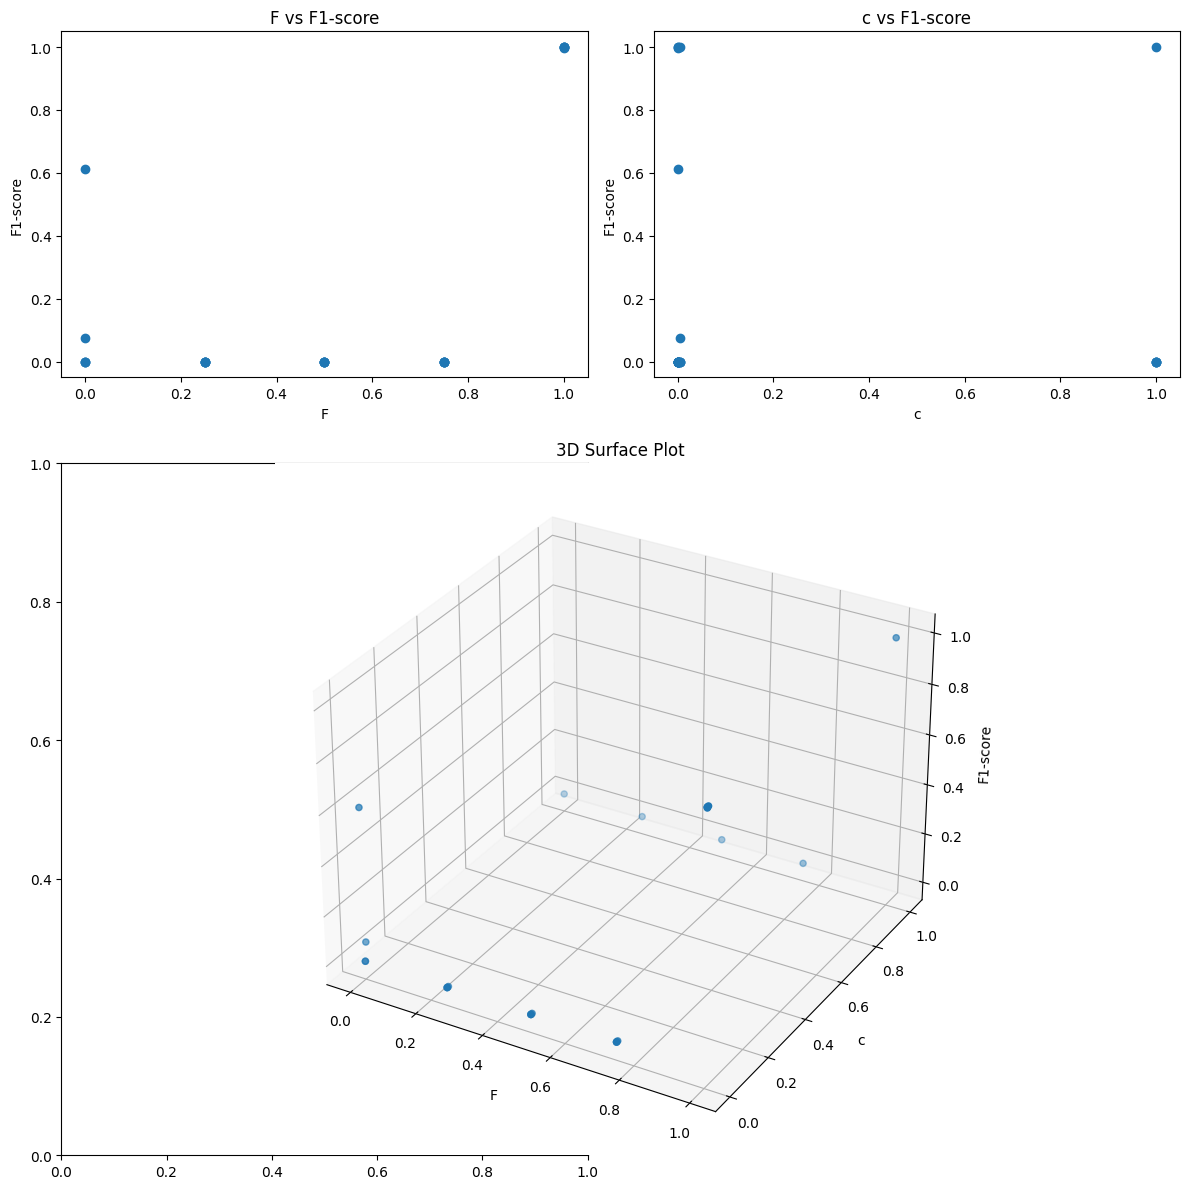

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x, y, and z coordinates
x = [key[0] for key in results.keys()]
y = [key[1] for key in results.keys()]
z = list(results.values())

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 2]})

# Remove the unused subplot
axs[1, 1].remove()

# Plot x vs z
axs[0, 0].scatter(x, z)
axs[0, 0].set_title('F vs F1-score')
axs[0, 0].set_xlabel('F')
axs[0, 0].set_ylabel('F1-score')

# Plot y vs z
axs[0, 1].scatter(y, z)
axs[0, 1].set_title('c vs F1-score')
axs[0, 1].set_xlabel('c')
axs[0, 1].set_ylabel('F1-score')

# Create a 3D plot in the second row, spanning two columns
ax_3d = fig.add_subplot(2, 2, (3, 4), projection='3d')

# Plot the surface
ax_3d.scatter(x, y, z)

# Add labels and title
ax_3d.set_xlabel('F')
ax_3d.set_ylabel('c')
ax_3d.set_zlabel('F1-score')
ax_3d.set_title('3D Surface Plot')

# Show the plots
plt.tight_layout()
plt.show()


In [47]:
import plotly.express as px
import pandas as pd


# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(results.items()), columns=['Coordinates', 'F1-score'])
df['F'] = df['Coordinates'].apply(lambda x: x[0])
df['c'] = df['Coordinates'].apply(lambda x: x[1])
df.drop('Coordinates', axis=1, inplace=True)

# Create the plot
fig = px.scatter_3d(df, x='F', y='c', z='F1-score')

# Show the plot
fig.show()
